Hub was disconnected.


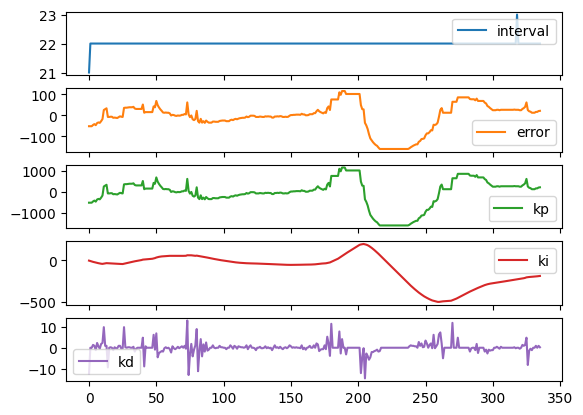

In [3]:
import asyncio
import pandas as pd
from time import time
from bleak import BleakScanner, BleakClient

UART_SERVICE_UUID = "6E400001-B5A3-F393-E0A9-E50E24DCCA9E"
UART_RX_CHAR_UUID = "6E400002-B5A3-F393-E0A9-E50E24DCCA9E"
UART_TX_CHAR_UUID = "6E400003-B5A3-F393-E0A9-E50E24DCCA9E"

HUB_NAME = "Robot Hub"

def hub_filter(device, ad):
    return device.name and device.name.lower() == HUB_NAME.lower()

def handle_disconnect(_):
    print("Hub was disconnected.")

last_update = time()

concatenated = ""
table = pd.DataFrame(columns=["interval", "error", "kp", "ki", "kd"])

def handle_rx(_, data: bytearray):
    global last_update
    global concatenated
    global table

    last_update = time()

    decoded = data.decode()
    concatenated += decoded
    
    split = concatenated.split("#", 1)

    if(len(split) == 2):
        interval, error, kp, ki, kd = map(lambda entry : float(entry), split[0].split(";"))
        table.loc[len(table.index)] = [interval, error, kp, ki, kd]

        concatenated = split[1]

device = await BleakScanner.find_device_by_filter(hub_filter)
client = BleakClient(device, disconnected_callback=handle_disconnect)

async def send(client, data):
    await client.write_gatt_char(rx_char, data)

try:
    await client.connect()
    await client.start_notify(UART_TX_CHAR_UUID, handle_rx)
    nus = client.services.get_service(UART_SERVICE_UUID)
    rx_char = nus.get_characteristic(UART_RX_CHAR_UUID)

    await send(client, b"10.00")
    await send(client, b"0.100")
    await send(client, b"5.000")

    while(time() - last_update < 2):
        await asyncio.sleep(1)

except Exception as e:
    print(e)
finally:
    await client.disconnect()

if(len(table.index) > 0):
    table.plot(subplots=True)
